In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.6 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import re
import torch
import nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm
from transformers import *
from transformers import DistilBertTokenizer,DistilBertModel

stopwords = set(stopwords.words('english'))
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
P = '/content/drive/MyDrive/hateful_memes/train.jsonl'
D = '/content/drive/MyDrive/hateful_memes/dev_seen.jsonl'
T = '/content/drive/MyDrive/hateful_memes/test_seen.jsonl'

In [9]:
train = pd.read_json(P, lines = True)
dev = pd.read_json(D,lines = True)
test = pd.read_json(T, lines = True)

In [10]:
display(train)

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


In [11]:
def Preprocess(dataset,column,label):
  Data = pd.DataFrame(columns = ['text', 'label']);
  # Data['text'] = data[column]
  Data['label'] = dataset[label]
  Data['id'] = dataset['id']
  clean_text = []
  maxlen = 0
  words_set = set()
  for i in dataset[column]:
    text = i
    text = re.sub(r'<.*?>',' ',text)#removing anchor html tags
    text = re.sub(r'[^A-Za-z0-9\s]',' ',text) #removing speacial characters
    text = re.sub(r'\s+',' ',text)#removing extra space
    text = text.lower()#lowercasing
    tokens = text.split(' ')
    clean_tokens = []
    for token in tokens:
      if(token not in stopwords):#removing stopwords
        clean_tokens.append(token)
      words_set.add(token)
      
    maxlen = max(maxlen, len(clean_tokens))
    txt = ' '.join(clean_tokens)
    clean_text.append(txt)
  Data['text']  = clean_text
  vocab_size = len(words_set)
  
  return Data,maxlen, vocab_size

In [12]:
ct,max_len,vocab_size =Preprocess(train,'text','label')
df_dev, max_len_dev, vocab_size_dev= Preprocess(dev,'text', 'label')
df_test, max_len_test, vocab_size_test= Preprocess(test,'text', 'label')

In [13]:
display(ct)

,text,label,id
0,character color matters,0,42953
1,afraid love everyone like ex,0,23058
2,putting bows pet,0,13894
3,love everything everybody except squirrels hat...,0,37408
4,everybody loves chocolate chip cookies even hi...,0,82403
...,...,...,...
8495,nobody wants hang auschwitz,1,10423
8496,god grants child 20 years marriage israel bomb...,1,98203
8497,gays social media equality body positivity lov...,1,36947
8498,bad day could siamese twin attached gay brothe...,1,16492


In [14]:
class Bert_Custom_dataset():
  def __init__(self,sentences, labels, max_len):
    self.sentences = sentences
    self.labels = np.array(labels)
    self.max_len = max_len
    self.dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    self.input_ids = []
    self.attention_masks = []
    for sent in self.sentences:
      dbert_inps=self.dbert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
      self.input_ids.append(dbert_inps['input_ids'])
      self.attention_masks.append(dbert_inps['attention_mask'])
    self.input_ids = np.asarray(self.input_ids)
    self.attention_masks = np.array(self.attention_masks)

  def __len__(self):
    return len(self.sentences)
  
  def __getitem__(self, index):
    id = self.input_ids[index]
    am = self.attention_masks[index]
    lbl = self.labels[index]

    return {
        'input_ids': id,
        'attention_mask': am,
        'label': lbl
    }

In [15]:
dataset = Bert_Custom_dataset(ct['text'],ct['label'],max_len)
data_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
)
valset = Bert_Custom_dataset(df_dev['text'],df_dev['label'], max_len)
val_loader = DataLoader(valset,batch_size = 16,shuffle = True)


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.28.1",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loa

In [16]:
class model(nn.Module):
  def __init__(self):
    super(model,self).__init__()
    self.dbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
    self.dense = nn.Linear(self.dbert_model.config.dim, 512)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.fc = nn.Linear(512, 2)

  def forward(self, input_ids, attention_mask):
    outputs = self.dbert_model(input_ids=input_ids, attention_mask=attention_mask)
    bert_output = outputs[0][:,0,:]
    dense_outputs = self.relu(self.dense(bert_output))
    dropout_outputs = self.dropout(dense_outputs)
    pred = self.fc(dropout_outputs)
    return pred

  def get_features(self, input_ids, attention_mask):
    with torch.no_grad():
      outputs = self.dbert_model(input_ids=input_ids, attention_mask=attention_mask)
      bert_output = outputs[0][:,0,:]
      features = self.relu(self.dense(bert_output))
    return features


In [17]:
if torch.cuda.is_available() is True:
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [18]:
print(device)

cuda


In [19]:
M = model().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(M.parameters(),lr =3e-5,weight_decay = 0.01)
losses1 = []
losses2 = []
train_accuracy = []
val_accuracy = []
for epoch in range(5):
  M.train()
  loss_train = 0
  loss_val = 0
  correct_train = 0
  correct_val = 0
  total_train = 0
  total_val = 0
  for batch in tqdm(data_loader):
    optimizer.zero_grad()
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    label = batch['label']
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    label = label.to(device)
    outputs = M(input_ids,attention_mask).to(device)
    loss = criterion(outputs,label)
    loss.backward()
    optimizer.step()
    loss_train+=loss.item()
    _,pred = outputs.max(1)
    correct_train+= pred.eq(label).sum().item()
    total_train+= label.size(0)

  accuracy = 100*(correct_train/total_train)
  train_accuracy.append(accuracy)
  losses1.append(loss_train)

  M.eval()
  with torch.no_grad():
    for batch_val in tqdm(val_loader):
      val_input = batch_val['input_ids']
      val_am = batch_val['attention_mask']
      val_label = batch_val['label']
      val_input = val_input.to(device)
      val_am = val_am.to(device)
      val_label = val_label.to(device)
      ots = M(val_input, val_am)
      loss = criterion(ots,val_label)
      loss_val+=loss.item()
      _,pred = ots.max(1)
      correct_val+= pred.eq(val_label).sum().item()
      total_val+= val_label.size(0)
    acc = 100*(correct_val/total_val)
    val_accuracy.append(acc)
    losses2.append(loss_val)    

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.28.1",
  "vocab_size": 30522
}



loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of DistilBertModel were initialized from the model checkpoint at disti

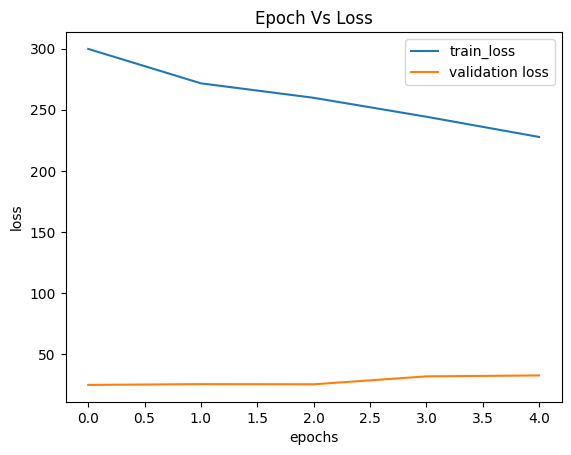

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(5)
plt.plot(x,losses1,label = 'train_loss')
plt.plot(x,losses2,label = 'validation loss')
plt.legend()
plt.title("Epoch Vs Loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

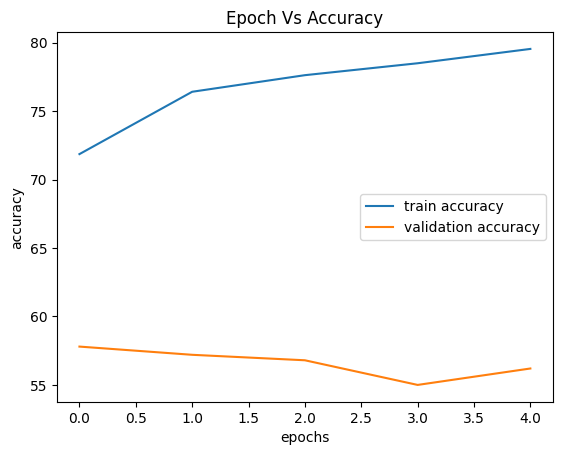

In [ ]:
x = np.arange(5)
plt.plot(x,train_accuracy,label = 'train accuracy')
plt.plot(x,val_accuracy,label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Epoch Vs Accuracy")
plt.show()

In [ ]:
test_set = Bert_Custom_dataset(df_test['text'],df_test['label'], max_len)
test_loader = DataLoader(test_set,batch_size = 16,shuffle = True)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_tok

In [ ]:
test_accuracy=[]
losses =[]
predictions = []
real = []
M.eval()
with torch.no_grad():
  loss_test=0
  for batch_val in tqdm(test_loader):
    test_input = batch_val['input_ids']
    test_am = batch_val['attention_mask']
    test_label = batch_val['label']
    test_input = test_input.to(device)
    test_am = test_am.to(device)
    test_label = test_label.to(device)
    ots = M(test_input, test_am)
    loss = criterion(ots,test_label)
    loss_test+=loss.item()
    _,pred = ots.max(1)
    predictions.extend(pred.cpu().numpy())
    real.extend(test_label.cpu().numpy())
    correct = pred.eq(test_label).sum().item()
    total = test_label.size(0)
  acc = 100*(correct/total)
  test_accuracy.append(acc)
  losses.append(loss_test) 

100%|██████████| 63/63 [00:01<00:00, 45.03it/s]


In [ ]:
print("Precision score - ", precision_score(real,predictions))

Precision score -  0.7040816326530612


In [ ]:
print("Recall score - ", recall_score(real,predictions))

Recall score -  0.2816326530612245


In [ ]:
print("F1 score - ", f1_score(real,predictions))

F1 score -  0.4224598930481283


In [ ]:
print("Accuracy score - ", accuracy_score(real,predictions))

Accuracy score -  0.568


In [ ]:
print("Classification Report - \n", classification_report(real,predictions))

Classification Report - 
               precision    recall  f1-score   support

           0       0.56      0.89      0.69       510
           1       0.70      0.28      0.40       490

    accuracy                           0.59      1000
   macro avg       0.63      0.58      0.55      1000
weighted avg       0.63      0.59      0.55      1000



In [20]:
import pickle

# assume filename is the name of the pickle file
filename = '/content/sample_details.pkl'

# open the file in binary mode and read the data
with open(filename, 'rb') as f:
    data = pickle.load(f)

# print the loaded data
print(data)

       ID Label
0   01359     0
1   74029     0
2   18406     0
3   46503     0
4   64038     0
..    ...   ...
95  27496     1
96  47265     1
97  74813     1
98  38765     1
99  93251     1

[100 rows x 2 columns]


In [21]:
sample_text_ids = []
for i in range(len(data)):
  x = int(data['ID'][i])
  sample_text_ids.append(x)

sample_data_text_0 = []
sample_data_label_0 = []
sample_data_text_1 = []
sample_data_label_1 = []
for i in range(len(test['id'])):
  if(test['id'][i] in sample_text_ids ):
    if(test['label'][i]==0):
      sample_data_text_0.append(test['text'][i])
      sample_data_label_0.append(test['label'][i])
    elif(test['label'][i]==1):
      sample_data_text_1.append(test['text'][i])
      sample_data_label_1.append(test['label'][i])


In [23]:
sample_dataset_0 = Bert_Custom_dataset(sample_data_text_0,sample_data_label_0, max_len)
sample_loader_0 = DataLoader(sample_dataset_0, batch_size=len(sample_data_text_0), shuffle=False)
sample_dataset_1 = Bert_Custom_dataset(sample_data_text_1,sample_data_label_1, max_len)
sample_loader_1 = DataLoader(sample_dataset_1, batch_size=len(sample_data_text_1), shuffle=False)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_tok

In [34]:
batch_0 = next(iter(sample_loader_0))
batch_1 = next(iter(sample_loader_1))

In [36]:
test_id_0 = batch_0['input_ids'].to(device)
test_am_0 = batch_0['attention_mask'].to(device)
labels_0 = batch_0['label'].to(device)
test_id_1 = batch_1['input_ids'].to(device)
test_am_1 = batch_1['attention_mask'].to(device)
labels_1 = batch_1['label'].to(device)

In [33]:
test_id_0

array([ 101, 1037, 4744, 2718, 2032, 2013, 2369,  102,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0])

In [40]:
features_0 = M.get_features(input_ids=test_id_0, attention_mask=test_am_0)
features_1 = M.get_features(input_ids=test_id_1, attention_mask=test_am_1)

In [41]:
F_0 = features_0.cpu()
labels_0 = labels_0.cpu()

In [42]:
F_1 = features_1.cpu()
labels_1 = labels_1.cpu()

In [43]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=42)
embeddings_0 = tsne.fit_transform(F_0)
embeddings_1 = tsne.fit_transform(F_1)

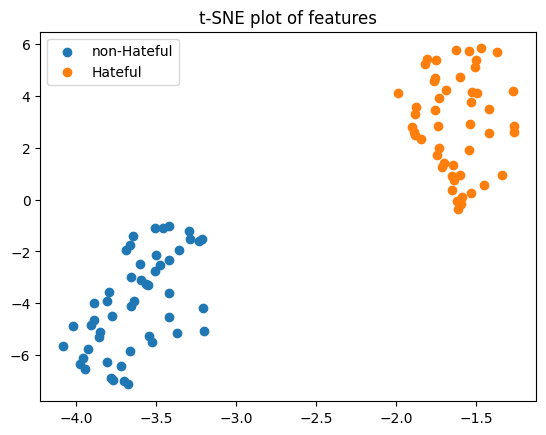

In [44]:
plt.scatter(embeddings_0[:,0], embeddings_0[:, 1], label='non-Hateful')
plt.scatter(embeddings_1[:, 0], embeddings_1[:, 1], label='Hateful')
plt.title('t-SNE plot of features')
plt.legend()
plt.show()

In [48]:
torch.save(M.state_dict(), '/content/drive/MyDrive/model.pt')

In [50]:
M.load_state_dict(torch.load('/content/drive/MyDrive/model.pt'))

<All keys matched successfully>